<a href="https://colab.research.google.com/github/Vinod1403/IIIT-Hyderabad-Tutorials/blob/main/STP_Module_4_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Module 4: Linear Classifiers & Gradient Descent

**Case Study: Predictive Modeling for Public Water Safety**

**Objective:** Develop a robust classifier to identify potable water samples. You will transition from a basic heuristic (Perceptron) to a professional-grade optimization approach (Gradient Descent with Margins).

# 1. Data Acquisition & Cleaning

In real-world data science, datasets are rarely perfect. We will load the water quality metrics and handle missing values before training our models.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
url = "https://raw.githubusercontent.com/nferran/tp_aprendizaje_de_maquina_I/main/water_potability.csv"
df = pd.read_csv(url)
df.fillna(df.mean(), inplace=True)
X = df.drop('Potability', axis=1).values
y = df['Potability'].values
y = np.where(y == 0, -1, 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
print(f"Dataset Loaded: {X_train.shape[0]} training samples, {X_train.shape[1]} features.")

Dataset Loaded: 2620 training samples, 9 features.


# 2. Phase 1: The Heuristic Approach (Perceptron)



In [12]:
class WaterPerceptron:
    def __init__(self, lr=0.01, epochs=50):
        self.lr = lr
        self.epochs = epochs
        self.w = None
        self.b = 0
        self.mistakes = []

    def fit(self, X, y):
        self.w = np.zeros(X.shape[1])

        for epoch in range(self.epochs):
            count = 0
            for i in range(len(y)):
                prediction = np.dot(X[i], self.w) + self.b

                if y[i] * prediction <= 0:
                    self.w += self.lr * y[i] * X[i]
                    self.b += self.lr * y[i]
                    count += 1

            self.mistakes.append(count)

    def predict(self, X):
        return np.sign(np.dot(X, self.w) + self.b)


# 3. Phase 2: Gradient Descent - Global Optimization

The Perceptron is unstable if the data isn't perfectly separable. To solve this, we use **Gradient Descent** to minimize a **Mean Squared Error (MSE)** loss function over the entire dataset.

In [13]:
class GDWaterClassifier:
    def __init__(self, lr=0.001, epochs=500):
        self.lr = lr
        self.epochs = epochs
        self.w = None
        self.b = 0
        self.cost_history = []

    def fit(self, X, y):
        self.w = np.zeros(X.shape[1])
        n = X.shape[0]

        for _ in range(self.epochs):
            z = np.dot(X, self.w) + self.b
            cost = (1/(2*n)) * np.sum((z - y) ** 2)
            self.cost_history.append(cost)

            dw = (1/n) * X.T.dot(z - y)
            db = (1/n) * np.sum(z - y)

            self.w -= self.lr * dw
            self.b -= self.lr * db

    def predict(self, X):
        return np.sign(np.dot(X, self.w) + self.b)


# 4. Phase 3: Margin Classifiers & Hinge Loss

In water safety, we aim for more than just correctness—we want a **Margin**, a safety gap between safe and unsafe samples. This is achieved using **Hinge Loss** combined with **L2 Regularization**.

The loss function is defined as:

$$
\text{Loss} = \lambda \|w\|^2_2 + \sum_{i} \max(0, 1 - y_i (w^T x_i + b))
$$

### Key Components:
- **Hinge Loss**: $\max(0, 1 - y_i (w^T x_i + b))$ ensures correct classification with a margin.
- **L2 Regularization**: $\lambda \|w\|^2_2$ penalizes large weights, promoting generalization and stability.


In [14]:
class MarginWaterClassifier:
    def __init__(self, lr=0.001, lambda_param=0.01, epochs=500):
        self.lr = lr
        self.lambda_param = lambda_param
        self.epochs = epochs
        self.w = None
        self.b = 0

    def fit(self, X, y):
        self.w = np.zeros(X.shape[1])

        for _ in range(self.epochs):
            for i, x_i in enumerate(X):
                condition = y[i] * (np.dot(x_i, self.w) + self.b) >= 1

                if condition:
                    self.w -= self.lr * (2 * self.lambda_param * self.w)
                else:
                    self.w -= self.lr * (2 * self.lambda_param * self.w - y[i] * x_i)
                    self.b -= self.lr * (-y[i])

    def predict(self, X):
        return np.sign(np.dot(X, self.w) + self.b)

# 5. Critical Analysis & Comparison

**Analysis Tasks:**
1. Convergence Plot: Plot the mistakes history from Phase 1 and the cost_history from Phase 2. Discuss why the Gradient Descent plot is smoother.
2. Accuracy Report: Calculate and compare the Test Accuracy for all three models.
3. Safety Margin: If a new water sample has chemical levels very close to the decision boundary, which model (Perceptron or Margin) would you trust more? Why?

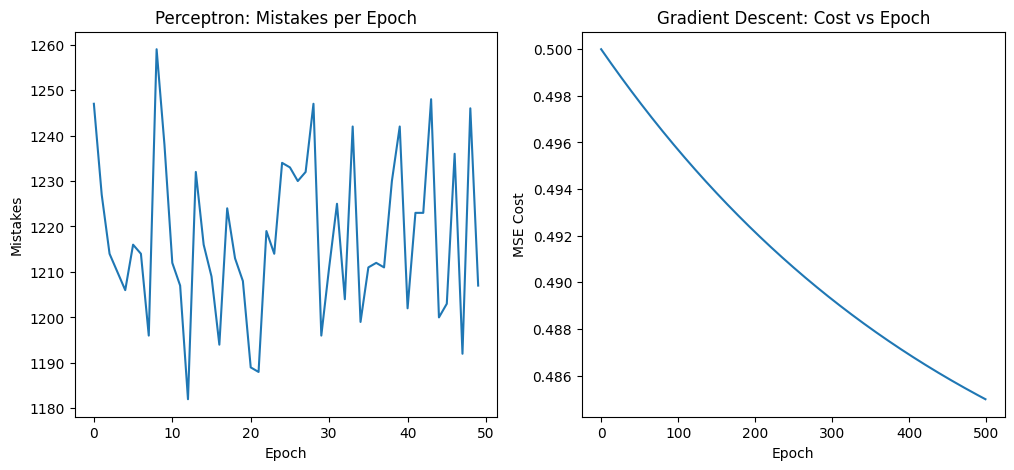

In [16]:
model_p = WaterPerceptron()
model_p.fit(X_train, y_train)

model_gd = GDWaterClassifier()
model_gd.fit(X_train, y_train)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(model_p.mistakes)
plt.title("Perceptron: Mistakes per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Mistakes")
plt.subplot(1,2,2)
plt.plot(model_gd.cost_history)
plt.title("Gradient Descent: Cost vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("MSE Cost")
plt.show()

In [17]:
from sklearn.metrics import accuracy_score

model_p = WaterPerceptron()
model_p.fit(X_train, y_train)

model_gd = GDWaterClassifier()
model_gd.fit(X_train, y_train)

model_margin = MarginWaterClassifier()
model_margin.fit(X_train, y_train)

acc_p = accuracy_score(y_test, model_p.predict(X_test))
acc_gd = accuracy_score(y_test, model_gd.predict(X_test))
acc_margin = accuracy_score(y_test, model_margin.predict(X_test))

acc_p, acc_gd, acc_margin

(0.5015243902439024, 0.6280487804878049, 0.6280487804878049)

# Discussion Questions

### Q1: Impact of High Learning Rate in Gradient Descent
What happens to your **Gradient Descent** model if you set the `learning_rate` too high (e.g., `1.0`)?


*High learning rate causes overshooting, instability, and divergence*

---

### Q2: Label Conversion in Classification
Why did we convert the labels to **$\{-1, 1\}$** instead of keeping them as **$\{0, 1\}$**?

*Labels {−1, +1} are required for hinge loss, symmetry, and margin learning.*

---

### Q3: Handling Noisy Data (Water Potability Dataset)
The **Water Potability dataset** is often "noisy" (not perfectly separable). Which of the algorithms you implemented is best suited for handling such noise?

*Margin-based classifiers handle noisy data best due to robustness and regularization*
